In [128]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [129]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [130]:
data = Digits()

In [131]:
data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
      dtype=float32)

In [132]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [133]:
class STNet(nn.Module):

    def __init__(
        self,
        dim: int,
        hidden: int = 128
    ):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dim, hidden),
                                 nn.ReLU(),
                                 nn.Linear(hidden, hidden),
                                 nn.ReLU(),
                                 nn.Linear(hidden, dim * 2)
                                 )
        
    def forward(self, x:torch.Tensor):
        st = self.net(x) # (B, 2D)
        s, t = st.chunk(2, dim=-1) #each is (B, D)
        return s, t

In [134]:
class AffineCoupling(nn.Module):
    def __init__(self, dim: int, mask: torch.Tensor, hidden: int = 128):
        super().__init__()
        assert mask.shape == (dim,)
        self.dim = dim
        # store mask only as a buffer to avoid duplicate attributes
        self.register_buffer("mask", mask.float())
        self.st = STNet(dim, hidden)
        
    def forward(self, x: torch.Tensor):
        m = self.mask
        x_masked = x * m
        s, t = self.st(x_masked)
        
        # bound the scale to keep exp(s) stable
        s = torch.tanh(s)
        s = s * (1.0 - m)
        t = t * (1.0 - m)
        
        y = x_masked + (1.0 - m) * (x * torch.exp(s) + t)
        
        logdet = s.sum(dim=-1)
        return y, logdet
    
    def inverse(self, y: torch.Tensor):
        m = self.mask
        y_masked = y * m
        s, t = self.st(y_masked)
        
        s = torch.tanh(s)
        s = s * (1.0 - m)
        t = t * (1.0 - m)
        
        x = y_masked + (1.0 - m) * ((y - t) * torch.exp(-s))
        
        logdet_inv = (-s).sum(dim=-1)
        return x, logdet_inv


In [135]:
def alternating_mask(dim: int, parity:int) -> torch.Tensor:
    idx = torch.arange(dim)
    return ((idx % 2) == parity).float()

In [136]:
class Permute(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        perm = torch.randperm(dim)
        invperm = torch.argsort(perm)
        self.register_buffer("perm", perm)
        self.register_buffer("invperm", invperm)

    def forward(self, x: torch.Tensor):
        return x[:, self.perm], torch.zeros(x.size(0), device=x.device)

    def inverse(self, y:torch.Tensor):
        return y[:, self.invperm], torch.zeros(y.size(0), device=y.device)

In [137]:
class RealNVP(nn.Module):
    def __init__(self, dim, n_coupling: int = 6, hidden: int = 128, use_permute: bool = False):
        super().__init__()
        self.dim = dim

        layers = []
        for k in range(n_coupling):
            mask = alternating_mask(dim, parity=k % 2)
            layers.append(AffineCoupling(dim, mask, hidden=hidden))
            if use_permute:
                layers.append(Permute(dim))
        self.layers = nn.ModuleList(layers)

    def _log_base_prob(self, z: torch.Tensor):
        return -0.5 * (z.pow(2).sum(dim=-1) + self.dim * math.log(2 * math.pi))

    def fwd(self, x: torch.Tensor):
        z = x
        sum_logdet = torch.zeros(x.size(0), device=x.device)
        for layer in self.layers:
            z, logdet = layer(z)
            sum_logdet += logdet
        return z, sum_logdet

    def inv(self, z: torch.Tensor):
        x = z
        sum_logdet_inv = torch.zeros(z.size(0), device=z.device)
        for layer in reversed(self.layers):
            x, logdet_inv = layer.inverse(x)
            sum_logdet_inv += logdet_inv
        return x, sum_logdet_inv

    def log_prob(self, x: torch.Tensor):
        z, sum_logdet = self.fwd(x)
        log_base = self._log_base_prob(z)
        return log_base + sum_logdet

    @torch.no_grad()
    def sample(self, n: int, device=None):
        device = device or next(self.parameters()).device
        z = torch.randn(n, self.dim, device=device)
        x, _ = self.inv(z)
        return x


In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [139]:
# two-moons toy dataset for 2D RealNVP training
moons, _ = datasets.make_moons(n_samples=5000, noise=0.1)
data_2d = torch.tensor(moons, dtype=torch.float32, device=device)


In [140]:
def train_realnvp_2d(model, data, steps=5000, batch_size=32, lr=1e-3, max_grad_norm=10.0):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for step in range(1, steps + 1):
        idx = torch.randint(0, data.size(0), (batch_size,), device=data.device)
        x = data[idx]

        logp = model.log_prob(x)  # (B,)
        loss = -logp.mean()

        opt.zero_grad()
        loss.backward()
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()

        if step % 500 == 0:
            print(f"step {step:5d} | NLL: {loss.item():.4f}")


step   500 | NLL: -90.5391
step  1000 | NLL: -103.9698
step  1500 | NLL: -112.6558
step  2000 | NLL: -118.7851
step  2500 | NLL: -124.8156
step  3000 | NLL: -124.0318


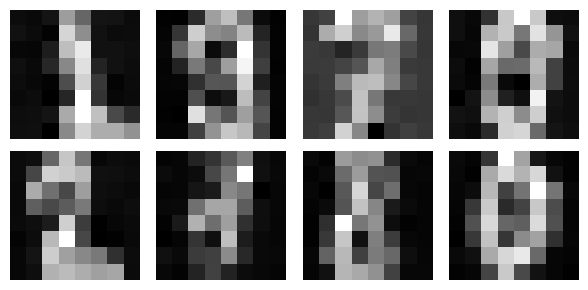

In [141]:
# Training RealNVP on Digits dataset (64-D)
# Digits values are in [0,16]; scale to [0,1] for stability.

digits = Digits(mode='train')
data_np = digits.data.astype(np.float32) / 16.0

# Ensure contiguous float32 array
import numpy as np
data_np = np.asarray(data_np, dtype=np.float32)

data_custom = torch.tensor(data_np, dtype=torch.float32, device=device)
D_custom = data_custom.shape[1]

model_custom = RealNVP(dim=D_custom, n_coupling=8, hidden=256, use_permute=False).to(device)

train_realnvp_2d(model_custom, data_custom, steps=3000, batch_size=256, lr=5e-4, max_grad_norm=10.0)

# Draw samples
your_samples = model_custom.sample(256, device=device).cpu()

# Optional: inspect a few samples as 8x8 images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(6,3))
for ax, img in zip(axes.flatten(), your_samples[:8]):
    ax.imshow(img.view(8, 8), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [142]:
def check_invertibility_model():
    torch.manual_seed(0)
    model = RealNVP(dim=2, n_coupling=6, hidden=64, use_permute=False)
    x = torch.randn(256, 2)

    z, ld1 = model.fwd(x)
    x2, ld2 = model.inv(z)

    max_err = (x - x2).abs().max().item()
    max_ld_err = (ld1 + ld2).abs().max().item()
    print("Model max |x-x2|:", max_err)
    print("Model max |ld1+ld2|:", max_ld_err)


check_invertibility_model()

Model max |x-x2|: 4.76837158203125e-07
Model max |ld1+ld2|: 2.086162567138672e-07


In [143]:
model = RealNVP(dim=2, n_coupling=8, hidden=128, use_permute=False).to(device)

train_realnvp_2d(model, data_2d, steps=5000, batch_size=256, lr=1e-3)

samples = model.sample(5000, device=device)  # (5000,2)


step   500 | NLL: 1.0695
step  1000 | NLL: 1.0237
step  1500 | NLL: 1.1224
step  2000 | NLL: 0.9575
step  2500 | NLL: 0.9941
step  3000 | NLL: 1.1389
step  3500 | NLL: 1.0591
step  4000 | NLL: 1.0291
step  4500 | NLL: 0.9676
step  5000 | NLL: 0.9944


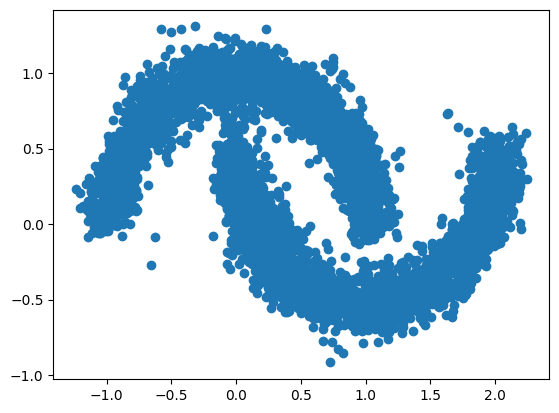

In [144]:
import matplotlib.pyplot as plt
plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu())

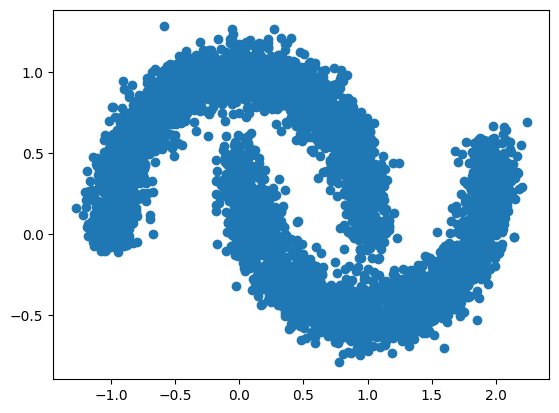

In [146]:
plt.scatter(moons[:, 0], moons[:, 1])